In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import Holt

In [2]:
class KalmanFilter():
    def __init__(self, processNoise, measurementNoise):
        super(KalmanFilter, self).__init__()
        self.processNoise = processNoise # Process noise = 0.0005
        self.measurementNoise = measurementNoise # Measurement noise = 20
        self.estimatedRSSI = 0.0 # calculated rssi
        self.errorCovarianceRSSI = 0.0 # calculated covariance
        self.isInitialized = False # initialization flag

    def applyFilter(self, rssi):
        priorRSSI = 0.0
        kalmanGain = 0.0
        priorErrorCovarianceRSSI = 0.0

        if not self.isInitialized:
            priorRSSI = rssi
            priorErrorCovarianceRSSI = 1
            self.isInitialized = True
        else:
            priorRSSI = self.estimatedRSSI
            priorErrorCovarianceRSSI = self.errorCovarianceRSSI + self.processNoise

        kalmanGain = priorErrorCovarianceRSSI / (priorErrorCovarianceRSSI + self.measurementNoise)
        self.estimatedRSSI = priorRSSI + (kalmanGain * (rssi - priorRSSI))
        self.errorCovarianceRSSI = (1 - kalmanGain) * priorErrorCovarianceRSSI

        return self.estimatedRSSI

In [3]:
class Confidence():
    def __init__(self):
        self.holt_z = 3.219 #2.58

    def holtCheck(self, fcast, se):
        MIN = fcast - ( self.holt_z * se )
        MAX = fcast + ( self.holt_z * se )
        return MIN, MAX

In [4]:
class HoltMethod():
    def __init__(self, level, trend):
        self.level = level
        self.trend = trend

        self.preL = 0
        self.preB = 0

    def holtForcast(self, x):
        
        if self.preL == 0:
            self.preL = x
            self.preB = 0
            return x
        
        l = (self.level * x) + (1 - self.level) * (self.preL + self.preB)
        b = self.trend * (l - self.preL) + (1 - self.trend) * self.preB

        res = l + b

        self.preL = l
        self.preB = b

        return res


In [5]:
class RSSI():
    def __init__(self):
        self.fcast = 0
        self.power_sum = 0
        self.se = 0
        self.idx = 2
        
        self.confi = Confidence()
        self.holt = HoltMethod(level = 0.9, trend = 0.4)
        self.KF = KalmanFilter(processNoise = 0.4, measurementNoise = 5)
        
        self.lower = 0
        self.upper = 0
        self.missC = 0

    def check_RSSI(self, rssi, test):
#         print('===================================================================')
#         print("forecast: ", self.fcast)
        pre_data = self.KF.applyFilter(rssi)
#         print("real: ", pre_data)
#         print('Lower bound: ', self.lower)
#         print('Upper bound: ', self.upper)
        
        if self.lower != 0 and self.upper != 0:
            if test:
#                 print("Miss Counter: ", self.missC)
                if pre_data < self.lower or pre_data > self.upper :
                    return True
                else:
                    return False
            else:
                if pre_data < self.lower or pre_data > self.upper :
                    self.missC += 1
#                     print('Miss!!')
        
    
    
        if self.fcast == 0:     
            self.fcast = self.holt.holtForcast(pre_data)
            return
    
        self.power_sum += np.power(pre_data - self.fcast, 2)

        if self.se == 0:
            self.se = np.sqrt(self.power_sum / ( self.idx - 1 ))
            self.fcast = self.holt.holtForcast(pre_data)
            self.idx += 1
            return
    
        fcast_pre = self.fcast
        se_pre = self.se
    
        self.fcast = self.holt.holtForcast(pre_data)
        self.lower, self.upper = self.confi.holtCheck(self.fcast, self.se)
        self.se = np.sqrt(self.power_sum / ( self.idx - 1))
        self.idx += 1
    
#         print('===================================================================')
        
        return False

In [6]:
res_0cm = []

miss_count_0cm = 0
total_count_0cm = 0

for j in range(1, 1001):
    print("=======================================")
    print("Start: " + str(j))
    df = pd.read_csv('./test_data0/data' + str(j) + '.csv')

    df_rssi = df['RSSI']
    
    RSSI_d = RSSI()
    flag = False
    miss_flag = False
    
    print("Data len: ", len(df_rssi))
    total_count_0cm += len(df_rssi)
    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 10:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], False)
                
        else:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], True)
            
            if rssi_res:
                flag = True
                
    miss_count_0cm += RSSI_d.missC
    
    if flag:
        res_0cm.append(True)
    else:
        res_0cm.append(False)
    print("=======================================")

Start: 1
Data len:  3016
Start: 2
Data len:  3206
Start: 3
Data len:  3301
Start: 4
Data len:  3051
Start: 5
Data len:  2976
Start: 6
Data len:  2921
Start: 7
Data len:  3086
Start: 8
Data len:  3121
Start: 9
Data len:  2886
Start: 10
Data len:  3046
Start: 11
Data len:  3041
Start: 12
Data len:  2901
Start: 13
Data len:  3241
Start: 14
Data len:  3161
Start: 15
Data len:  3121
Start: 16
Data len:  2881
Start: 17
Data len:  3056
Start: 18
Data len:  2966
Start: 19
Data len:  2961
Start: 20
Data len:  3046
Start: 21
Data len:  2851
Start: 22
Data len:  2876
Start: 23
Data len:  3001
Start: 24
Data len:  2881
Start: 25
Data len:  3081
Start: 26
Data len:  2911
Start: 27
Data len:  3021
Start: 28
Data len:  2976
Start: 29
Data len:  2996
Start: 30
Data len:  2806
Start: 31
Data len:  3051
Start: 32
Data len:  3066
Start: 33
Data len:  2941
Start: 34
Data len:  2891
Start: 35
Data len:  3141
Start: 36
Data len:  3251
Start: 37
Data len:  3046
Start: 38
Data len:  3361
Start: 39
Data len:  

Start: 82
Data len:  2711
Start: 83
Data len:  3271
Start: 84
Data len:  3081
Start: 85
Data len:  2851
Start: 86
Data len:  2916
Start: 87
Data len:  2786
Start: 88
Data len:  2881
Start: 89
Data len:  3191
Start: 90
Data len:  3156
Start: 91
Data len:  2956
Start: 92
Data len:  3181
Start: 93
Data len:  3201
Start: 94
Data len:  2931
Start: 95
Data len:  3246
Start: 96
Data len:  3066
Start: 97
Data len:  2911
Start: 98
Data len:  2786
Start: 99
Data len:  2906
Start: 100
Data len:  3121
Start: 101
Data len:  3081
Start: 102
Data len:  2696
Start: 103
Data len:  2971
Start: 104
Data len:  2741
Start: 105
Data len:  3121
Start: 106
Data len:  3321
Start: 107
Data len:  3036
Start: 108
Data len:  3056
Start: 109
Data len:  3136
Start: 110
Data len:  3056
Start: 111
Data len:  2821
Start: 112
Data len:  2736
Start: 113
Data len:  2836
Start: 114
Data len:  2806
Start: 115
Data len:  2881
Start: 116
Data len:  3196
Start: 117
Data len:  3101
Start: 118
Data len:  2941
Start: 119
Data len

Start: 161
Data len:  3011
Start: 162
Data len:  3086
Start: 163
Data len:  3296
Start: 164
Data len:  2931
Start: 165
Data len:  2951
Start: 166
Data len:  3101
Start: 167
Data len:  3126
Start: 168
Data len:  2971
Start: 169
Data len:  2931
Start: 170
Data len:  2861
Start: 171
Data len:  3131
Start: 172
Data len:  2911
Start: 173
Data len:  3111
Start: 174
Data len:  2726
Start: 175
Data len:  2931
Start: 176
Data len:  3086
Start: 177
Data len:  2801
Start: 178
Data len:  3431
Start: 179
Data len:  2996
Start: 180
Data len:  3226
Start: 181
Data len:  3131
Start: 182
Data len:  3316
Start: 183
Data len:  2786
Start: 184
Data len:  2841
Start: 185
Data len:  3086
Start: 186
Data len:  2886
Start: 187
Data len:  2856
Start: 188
Data len:  3106
Start: 189
Data len:  3006
Start: 190
Data len:  2931
Start: 191
Data len:  2706
Start: 192
Data len:  3056
Start: 193
Data len:  2786
Start: 194
Data len:  3011
Start: 195
Data len:  3261
Start: 196
Data len:  2801
Start: 197
Data len:  3016
S

Start: 238
Data len:  2901
Start: 239
Data len:  2981
Start: 240
Data len:  3151
Start: 241
Data len:  3211
Start: 242
Data len:  3021
Start: 243
Data len:  2931
Start: 244
Data len:  2886
Start: 245
Data len:  2926
Start: 246
Data len:  2806
Start: 247
Data len:  2846
Start: 248
Data len:  2951
Start: 249
Data len:  3036
Start: 250
Data len:  2946
Start: 251
Data len:  3151
Start: 252
Data len:  3156
Start: 253
Data len:  2986
Start: 254
Data len:  2871
Start: 255
Data len:  3186
Start: 256
Data len:  3346
Start: 257
Data len:  2846
Start: 258
Data len:  2981
Start: 259
Data len:  2991
Start: 260
Data len:  3121
Start: 261
Data len:  2946
Start: 262
Data len:  3181
Start: 263
Data len:  2921
Start: 264
Data len:  2906
Start: 265
Data len:  2911
Start: 266
Data len:  3016
Start: 267
Data len:  3316
Start: 268
Data len:  3181
Start: 269
Data len:  2791
Start: 270
Data len:  2831
Start: 271
Data len:  2666
Start: 272
Data len:  2816
Start: 273
Data len:  2801
Start: 274
Data len:  2981
S

Data len:  2861
Start: 319
Data len:  2891
Start: 320
Data len:  2701
Start: 321
Data len:  2806
Start: 322
Data len:  2911
Start: 323
Data len:  3081
Start: 324
Data len:  2896
Start: 325
Data len:  3161
Start: 326
Data len:  3066
Start: 327
Data len:  2836
Start: 328
Data len:  2951
Start: 329
Data len:  3181
Start: 330
Data len:  3181
Start: 331
Data len:  3296
Start: 332
Data len:  2926
Start: 333
Data len:  3101
Start: 334
Data len:  2971
Start: 335
Data len:  3056
Start: 336
Data len:  2981
Start: 337
Data len:  3046
Start: 338
Data len:  2991
Start: 339
Data len:  3051
Start: 340
Data len:  3356
Start: 341
Data len:  2926
Start: 342
Data len:  3046
Start: 343
Data len:  3336
Start: 344
Data len:  3001
Start: 345
Data len:  3081
Start: 346
Data len:  3006
Start: 347
Data len:  3031
Start: 348
Data len:  2891
Start: 349
Data len:  3331
Start: 350
Data len:  3046
Start: 351
Data len:  2876
Start: 352
Data len:  3071
Start: 353
Data len:  2841
Start: 354
Data len:  2906
Start: 355
D

Start: 399
Data len:  3081
Start: 400
Data len:  2981
Start: 401
Data len:  2996
Start: 402
Data len:  3176
Start: 403
Data len:  2941
Start: 404
Data len:  3036
Start: 405
Data len:  3036
Start: 406
Data len:  2836
Start: 407
Data len:  2841
Start: 408
Data len:  3096
Start: 409
Data len:  3091
Start: 410
Data len:  3246
Start: 411
Data len:  2996
Start: 412
Data len:  3151
Start: 413
Data len:  3186
Start: 414
Data len:  3031
Start: 415
Data len:  2871
Start: 416
Data len:  2966
Start: 417
Data len:  3161
Start: 418
Data len:  3081
Start: 419
Data len:  2996
Start: 420
Data len:  2861
Start: 421
Data len:  3296
Start: 422
Data len:  2991
Start: 423
Data len:  3156
Start: 424
Data len:  3061
Start: 425
Data len:  2946
Start: 426
Data len:  3181
Start: 427
Data len:  3026
Start: 428
Data len:  2901
Start: 429
Data len:  2941
Start: 430
Data len:  3086
Start: 431
Data len:  3001
Start: 432
Data len:  2646
Start: 433
Data len:  3196
Start: 434
Data len:  3191
Start: 435
Data len:  2966
S

Start: 479
Data len:  2906
Start: 480
Data len:  3166
Start: 481
Data len:  2971
Start: 482
Data len:  3131
Start: 483
Data len:  3261
Start: 484
Data len:  3056
Start: 485
Data len:  2881
Start: 486
Data len:  3461
Start: 487
Data len:  3206
Start: 488
Data len:  2876
Start: 489
Data len:  2866
Start: 490
Data len:  3036
Start: 491
Data len:  2991
Start: 492
Data len:  2966
Start: 493
Data len:  2916
Start: 494
Data len:  3151
Start: 495
Data len:  2876
Start: 496
Data len:  3146
Start: 497
Data len:  3056
Start: 498
Data len:  2996
Start: 499
Data len:  3321
Start: 500
Data len:  3051
Start: 501
Data len:  3271
Start: 502
Data len:  2906
Start: 503
Data len:  2866
Start: 504
Data len:  3186
Start: 505
Data len:  2881
Start: 506
Data len:  3291
Start: 507
Data len:  2971
Start: 508
Data len:  3106
Start: 509
Data len:  2601
Start: 510
Data len:  3021
Start: 511
Data len:  3251
Start: 512
Data len:  3086
Start: 513
Data len:  3186
Start: 514
Data len:  2976
Start: 515
Data len:  2826
S

Start: 558
Data len:  3121
Start: 559
Data len:  2781
Start: 560
Data len:  2961
Start: 561
Data len:  3126
Start: 562
Data len:  2871
Start: 563
Data len:  2951
Start: 564
Data len:  3121
Start: 565
Data len:  2896
Start: 566
Data len:  2841
Start: 567
Data len:  2691
Start: 568
Data len:  3026
Start: 569
Data len:  2751
Start: 570
Data len:  3316
Start: 571
Data len:  3196
Start: 572
Data len:  3296
Start: 573
Data len:  3261
Start: 574
Data len:  3126
Start: 575
Data len:  3166
Start: 576
Data len:  3196
Start: 577
Data len:  2811
Start: 578
Data len:  2821
Start: 579
Data len:  3036
Start: 580
Data len:  3091
Start: 581
Data len:  3016
Start: 582
Data len:  3206
Start: 583
Data len:  2741
Start: 584
Data len:  2731
Start: 585
Data len:  2951
Start: 586
Data len:  3096
Start: 587
Data len:  3006
Start: 588
Data len:  2921
Start: 589
Data len:  3341
Start: 590
Data len:  2901
Start: 591
Data len:  3361
Start: 592
Data len:  3086
Start: 593
Data len:  2861
Start: 594
Data len:  3131
S

Start: 638
Data len:  3011
Start: 639
Data len:  2796
Start: 640
Data len:  3031
Start: 641
Data len:  3096
Start: 642
Data len:  2926
Start: 643
Data len:  3071
Start: 644
Data len:  3081
Start: 645
Data len:  2886
Start: 646
Data len:  2951
Start: 647
Data len:  3276
Start: 648
Data len:  2991
Start: 649
Data len:  3001
Start: 650
Data len:  2816
Start: 651
Data len:  3036
Start: 652
Data len:  3126
Start: 653
Data len:  3211
Start: 654
Data len:  3051
Start: 655
Data len:  3211
Start: 656
Data len:  3131
Start: 657
Data len:  3066
Start: 658
Data len:  2876
Start: 659
Data len:  3101
Start: 660
Data len:  2946
Start: 661
Data len:  2961
Start: 662
Data len:  3116
Start: 663
Data len:  2741
Start: 664
Data len:  2986
Start: 665
Data len:  2971
Start: 666
Data len:  2986
Start: 667
Data len:  3101
Start: 668
Data len:  3046
Start: 669
Data len:  3136
Start: 670
Data len:  2781
Start: 671
Data len:  2986
Start: 672
Data len:  3066
Start: 673
Data len:  3111
Start: 674
Data len:  2871
S

Start: 717
Data len:  3191
Start: 718
Data len:  3161
Start: 719
Data len:  3061
Start: 720
Data len:  2846
Start: 721
Data len:  2936
Start: 722
Data len:  3236
Start: 723
Data len:  3026
Start: 724
Data len:  2936
Start: 725
Data len:  3051
Start: 726
Data len:  2646
Start: 727
Data len:  3026
Start: 728
Data len:  3046
Start: 729
Data len:  3311
Start: 730
Data len:  2881
Start: 731
Data len:  2746
Start: 732
Data len:  3126
Start: 733
Data len:  2896
Start: 734
Data len:  2946
Start: 735
Data len:  3006
Start: 736
Data len:  3036
Start: 737
Data len:  2996
Start: 738
Data len:  3036
Start: 739
Data len:  2951
Start: 740
Data len:  2641
Start: 741
Data len:  2751
Start: 742
Data len:  3076
Start: 743
Data len:  3026
Start: 744
Data len:  3161
Start: 745
Data len:  3181
Start: 746
Data len:  3161
Start: 747
Data len:  3006
Start: 748
Data len:  3296
Start: 749
Data len:  3041
Start: 750
Data len:  2841
Start: 751
Data len:  3056
Start: 752
Data len:  3071
Start: 753
Data len:  2966
S

Start: 794
Data len:  2791
Start: 795
Data len:  2866
Start: 796
Data len:  3296
Start: 797
Data len:  3081
Start: 798
Data len:  3121
Start: 799
Data len:  3121
Start: 800
Data len:  2851
Start: 801
Data len:  3281
Start: 802
Data len:  2956
Start: 803
Data len:  3056
Start: 804
Data len:  2976
Start: 805
Data len:  3061
Start: 806
Data len:  2726
Start: 807
Data len:  3176
Start: 808
Data len:  3146
Start: 809
Data len:  3331
Start: 810
Data len:  2926
Start: 811
Data len:  3121
Start: 812
Data len:  2961
Start: 813
Data len:  2921
Start: 814
Data len:  2931
Start: 815
Data len:  3056
Start: 816
Data len:  3296
Start: 817
Data len:  2861
Start: 818
Data len:  2721
Start: 819
Data len:  3046
Start: 820
Data len:  3086
Start: 821
Data len:  3186
Start: 822
Data len:  2841
Start: 823
Data len:  3136
Start: 824
Data len:  3011
Start: 825
Data len:  3131
Start: 826
Data len:  2896
Start: 827
Data len:  2991
Start: 828
Data len:  3071
Start: 829
Data len:  2991
Start: 830
Data len:  3061
S

Start: 874
Data len:  2946
Start: 875
Data len:  2856
Start: 876
Data len:  3206
Start: 877
Data len:  3031
Start: 878
Data len:  3071
Start: 879
Data len:  3071
Start: 880
Data len:  3211
Start: 881
Data len:  3186
Start: 882
Data len:  2871
Start: 883
Data len:  3006
Start: 884
Data len:  3061
Start: 885
Data len:  3086
Start: 886
Data len:  3286
Start: 887
Data len:  3041
Start: 888
Data len:  2946
Start: 889
Data len:  3106
Start: 890
Data len:  2936
Start: 891
Data len:  3026
Start: 892
Data len:  3036
Start: 893
Data len:  3406
Start: 894
Data len:  3126
Start: 895
Data len:  3061
Start: 896
Data len:  3001
Start: 897
Data len:  2851
Start: 898
Data len:  3171
Start: 899
Data len:  2811
Start: 900
Data len:  3316
Start: 901
Data len:  3156
Start: 902
Data len:  3186
Start: 903
Data len:  3056
Start: 904
Data len:  3096
Start: 905
Data len:  3161
Start: 906
Data len:  3051
Start: 907
Data len:  3061
Start: 908
Data len:  3026
Start: 909
Data len:  3071
Start: 910
Data len:  3126
S

Data len:  3041
Start: 951
Data len:  2846
Start: 952
Data len:  3026
Start: 953
Data len:  2861
Start: 954
Data len:  3031
Start: 955
Data len:  3051
Start: 956
Data len:  3146
Start: 957
Data len:  3046
Start: 958
Data len:  3191
Start: 959
Data len:  3021
Start: 960
Data len:  3186
Start: 961
Data len:  3156
Start: 962
Data len:  2906
Start: 963
Data len:  3016
Start: 964
Data len:  3136
Start: 965
Data len:  3041
Start: 966
Data len:  3271
Start: 967
Data len:  3216
Start: 968
Data len:  3016
Start: 969
Data len:  2971
Start: 970
Data len:  2741
Start: 971
Data len:  3296
Start: 972
Data len:  2916
Start: 973
Data len:  2951
Start: 974
Data len:  2891
Start: 975
Data len:  2846
Start: 976
Data len:  3156
Start: 977
Data len:  3021
Start: 978
Data len:  3096
Start: 979
Data len:  2966
Start: 980
Data len:  2956
Start: 981
Data len:  2916
Start: 982
Data len:  2761
Start: 983
Data len:  2966
Start: 984
Data len:  3081
Start: 985
Data len:  3166
Start: 986
Data len:  2981
Start: 987
D

In [7]:
res_50cm = []

miss_count_50cm = 0
total_count_50cm = 0

for j in range(1, 1001):
    print("=======================================")
    print("Start: " + str(j))
    df = pd.read_csv('./test_data1/data' + str(j) + '.csv')

    df_rssi = df['RSSI']
    
    RSSI_d = RSSI()
    flag = False
    miss_flag = False
    
    print("Data len: ", len(df_rssi))
    total_count_50cm += len(df_rssi)
    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 10:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], False)
                
        else:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], True)
            
            if rssi_res:
                flag = True
                
    miss_count_50cm += RSSI_d.missC
    
    if flag:
        res_50cm.append(True)
    else:
        res_50cm.append(False)
    print("=======================================")

Start: 1
Data len:  2961
Start: 2
Data len:  2991
Start: 3
Data len:  3021
Start: 4
Data len:  2966
Start: 5
Data len:  2961
Start: 6
Data len:  3216
Start: 7
Data len:  2771
Start: 8
Data len:  2916
Start: 9
Data len:  3176
Start: 10
Data len:  2991
Start: 11
Data len:  3161
Start: 12
Data len:  2886
Start: 13
Data len:  3066
Start: 14
Data len:  2956
Start: 15
Data len:  2856
Start: 16
Data len:  3281
Start: 17
Data len:  3006
Start: 18
Data len:  2946
Start: 19
Data len:  3096
Start: 20
Data len:  2911
Start: 21
Data len:  2916
Start: 22
Data len:  3021
Start: 23
Data len:  3136
Start: 24
Data len:  2986
Start: 25
Data len:  3016
Start: 26
Data len:  2876
Start: 27
Data len:  2971
Start: 28
Data len:  2946
Start: 29
Data len:  2896
Start: 30
Data len:  2976
Start: 31
Data len:  3186
Start: 32
Data len:  2851
Start: 33
Data len:  2951
Start: 34
Data len:  2951
Start: 35
Data len:  2936
Start: 36
Data len:  2916
Start: 37
Data len:  2871
Start: 38
Data len:  3096
Start: 39
Data len:  

Start: 80
Data len:  2931
Start: 81
Data len:  3036
Start: 82
Data len:  2921
Start: 83
Data len:  3061
Start: 84
Data len:  3306
Start: 85
Data len:  2981
Start: 86
Data len:  2941
Start: 87
Data len:  2881
Start: 88
Data len:  2801
Start: 89
Data len:  3156
Start: 90
Data len:  3306
Start: 91
Data len:  2881
Start: 92
Data len:  2861
Start: 93
Data len:  2986
Start: 94
Data len:  3296
Start: 95
Data len:  3031
Start: 96
Data len:  2641
Start: 97
Data len:  2726
Start: 98
Data len:  3071
Start: 99
Data len:  3061
Start: 100
Data len:  2971
Start: 101
Data len:  2516
Start: 102
Data len:  3086
Start: 103
Data len:  2911
Start: 104
Data len:  2821
Start: 105
Data len:  3061
Start: 106
Data len:  3266
Start: 107
Data len:  2931
Start: 108
Data len:  2711
Start: 109
Data len:  3196
Start: 110
Data len:  3231
Start: 111
Data len:  3061
Start: 112
Data len:  3186
Start: 113
Data len:  2956
Start: 114
Data len:  3081
Start: 115
Data len:  2976
Start: 116
Data len:  3036
Start: 117
Data len: 

Start: 160
Data len:  3056
Start: 161
Data len:  3146
Start: 162
Data len:  2796
Start: 163
Data len:  3011
Start: 164
Data len:  2926
Start: 165
Data len:  3036
Start: 166
Data len:  3066
Start: 167
Data len:  3046
Start: 168
Data len:  2866
Start: 169
Data len:  3046
Start: 170
Data len:  3151
Start: 171
Data len:  3021
Start: 172
Data len:  2911
Start: 173
Data len:  3101
Start: 174
Data len:  3011
Start: 175
Data len:  2816
Start: 176
Data len:  2986
Start: 177
Data len:  3336
Start: 178
Data len:  2876
Start: 179
Data len:  3056
Start: 180
Data len:  3036
Start: 181
Data len:  3116
Start: 182
Data len:  3036
Start: 183
Data len:  3146
Start: 184
Data len:  2746
Start: 185
Data len:  3111
Start: 186
Data len:  3156
Start: 187
Data len:  3106
Start: 188
Data len:  2861
Start: 189
Data len:  2846
Start: 190
Data len:  2951
Start: 191
Data len:  3101
Start: 192
Data len:  2961
Start: 193
Data len:  2861
Start: 194
Data len:  2906
Start: 195
Data len:  3121
Start: 196
Data len:  3146
S

Start: 239
Data len:  2741
Start: 240
Data len:  3181
Start: 241
Data len:  3136
Start: 242
Data len:  3011
Start: 243
Data len:  3086
Start: 244
Data len:  3086
Start: 245
Data len:  2886
Start: 246
Data len:  2941
Start: 247
Data len:  3066
Start: 248
Data len:  2801
Start: 249
Data len:  3196
Start: 250
Data len:  3086
Start: 251
Data len:  3346
Start: 252
Data len:  2991
Start: 253
Data len:  3276
Start: 254
Data len:  2861
Start: 255
Data len:  2901
Start: 256
Data len:  3251
Start: 257
Data len:  2721
Start: 258
Data len:  3066
Start: 259
Data len:  2881
Start: 260
Data len:  2961
Start: 261
Data len:  2901
Start: 262
Data len:  3176
Start: 263
Data len:  3061
Start: 264
Data len:  3061
Start: 265
Data len:  2911
Start: 266
Data len:  2931
Start: 267
Data len:  3151
Start: 268
Data len:  2766
Start: 269
Data len:  3086
Start: 270
Data len:  3451
Start: 271
Data len:  2961
Start: 272
Data len:  2841
Start: 273
Data len:  2766
Start: 274
Data len:  2891
Start: 275
Data len:  3061
S

Start: 318
Data len:  3126
Start: 319
Data len:  3251
Start: 320
Data len:  3056
Start: 321
Data len:  2741
Start: 322
Data len:  2996
Start: 323
Data len:  3161
Start: 324
Data len:  2866
Start: 325
Data len:  3186
Start: 326
Data len:  2766
Start: 327
Data len:  2781
Start: 328
Data len:  3026
Start: 329
Data len:  3216
Start: 330
Data len:  2901
Start: 331
Data len:  2846
Start: 332
Data len:  3151
Start: 333
Data len:  2931
Start: 334
Data len:  3106
Start: 335
Data len:  2931
Start: 336
Data len:  3086
Start: 337
Data len:  2976
Start: 338
Data len:  2926
Start: 339
Data len:  3016
Start: 340
Data len:  2991
Start: 341
Data len:  3046
Start: 342
Data len:  2986
Start: 343
Data len:  3011
Start: 344
Data len:  3266
Start: 345
Data len:  3001
Start: 346
Data len:  3096
Start: 347
Data len:  2836
Start: 348
Data len:  2901
Start: 349
Data len:  3061
Start: 350
Data len:  3106
Start: 351
Data len:  2901
Start: 352
Data len:  2656
Start: 353
Data len:  2881
Start: 354
Data len:  2756
S

Start: 397
Data len:  3046
Start: 398
Data len:  2826
Start: 399
Data len:  3036
Start: 400
Data len:  2856
Start: 401
Data len:  3146
Start: 402
Data len:  3201
Start: 403
Data len:  3096
Start: 404
Data len:  3026
Start: 405
Data len:  3091
Start: 406
Data len:  3006
Start: 407
Data len:  3011
Start: 408
Data len:  2941
Start: 409
Data len:  2961
Start: 410
Data len:  3201
Start: 411
Data len:  3071
Start: 412
Data len:  2731
Start: 413
Data len:  2691
Start: 414
Data len:  2976
Start: 415
Data len:  3221
Start: 416
Data len:  2761
Start: 417
Data len:  3046
Start: 418
Data len:  3166
Start: 419
Data len:  2781
Start: 420
Data len:  2806
Start: 421
Data len:  2976
Start: 422
Data len:  2931
Start: 423
Data len:  3196
Start: 424
Data len:  3196
Start: 425
Data len:  2981
Start: 426
Data len:  3121
Start: 427
Data len:  2826
Start: 428
Data len:  2886
Start: 429
Data len:  2951
Start: 430
Data len:  2941
Start: 431
Data len:  2811
Start: 432
Data len:  3116
Start: 433
Data len:  3006
S

Data len:  2951
Start: 478
Data len:  2946
Start: 479
Data len:  2861
Start: 480
Data len:  2936
Start: 481
Data len:  3016
Start: 482
Data len:  3036
Start: 483
Data len:  2776
Start: 484
Data len:  3026
Start: 485
Data len:  2636
Start: 486
Data len:  3231
Start: 487
Data len:  2911
Start: 488
Data len:  3036
Start: 489
Data len:  3041
Start: 490
Data len:  3116
Start: 491
Data len:  2971
Start: 492
Data len:  2961
Start: 493
Data len:  3026
Start: 494
Data len:  2941
Start: 495
Data len:  2846
Start: 496
Data len:  3051
Start: 497
Data len:  2881
Start: 498
Data len:  3081
Start: 499
Data len:  3106
Start: 500
Data len:  3251
Start: 501
Data len:  2871
Start: 502
Data len:  3071
Start: 503
Data len:  2891
Start: 504
Data len:  3066
Start: 505
Data len:  3081
Start: 506
Data len:  2876
Start: 507
Data len:  3146
Start: 508
Data len:  2936
Start: 509
Data len:  2986
Start: 510
Data len:  2966
Start: 511
Data len:  2951
Start: 512
Data len:  3136
Start: 513
Data len:  2466
Start: 514
D

Start: 556
Data len:  2701
Start: 557
Data len:  3066
Start: 558
Data len:  2861
Start: 559
Data len:  3066
Start: 560
Data len:  3046
Start: 561
Data len:  3046
Start: 562
Data len:  3006
Start: 563
Data len:  2861
Start: 564
Data len:  3086
Start: 565
Data len:  3341
Start: 566
Data len:  3196
Start: 567
Data len:  2896
Start: 568
Data len:  3106
Start: 569
Data len:  2881
Start: 570
Data len:  3001
Start: 571
Data len:  3311
Start: 572
Data len:  3091
Start: 573
Data len:  2851
Start: 574
Data len:  3226
Start: 575
Data len:  2871
Start: 576
Data len:  3241
Start: 577
Data len:  2926
Start: 578
Data len:  2971
Start: 579
Data len:  3331
Start: 580
Data len:  2856
Start: 581
Data len:  2986
Start: 582
Data len:  2936
Start: 583
Data len:  2821
Start: 584
Data len:  3096
Start: 585
Data len:  3176
Start: 586
Data len:  2786
Start: 587
Data len:  3061
Start: 588
Data len:  3506
Start: 589
Data len:  3036
Start: 590
Data len:  3081
Start: 591
Data len:  2916
Start: 592
Data len:  3051
S

Start: 636
Data len:  3256
Start: 637
Data len:  2966
Start: 638
Data len:  3091
Start: 639
Data len:  2881
Start: 640
Data len:  3156
Start: 641
Data len:  3091
Start: 642
Data len:  3036
Start: 643
Data len:  3016
Start: 644
Data len:  3036
Start: 645
Data len:  2941
Start: 646
Data len:  3001
Start: 647
Data len:  2996
Start: 648
Data len:  3191
Start: 649
Data len:  2976
Start: 650
Data len:  3501
Start: 651
Data len:  2951
Start: 652
Data len:  3076
Start: 653
Data len:  2886
Start: 654
Data len:  2946
Start: 655
Data len:  3086
Start: 656
Data len:  2656
Start: 657
Data len:  3086
Start: 658
Data len:  3161
Start: 659
Data len:  2971
Start: 660
Data len:  2741
Start: 661
Data len:  2931
Start: 662
Data len:  3101
Start: 663
Data len:  3006
Start: 664
Data len:  2856
Start: 665
Data len:  2801
Start: 666
Data len:  2931
Start: 667
Data len:  2931
Start: 668
Data len:  3006
Start: 669
Data len:  3006
Start: 670
Data len:  3131
Start: 671
Data len:  2826
Start: 672
Data len:  2816
S

Start: 715
Data len:  3096
Start: 716
Data len:  3131
Start: 717
Data len:  3036
Start: 718
Data len:  3056
Start: 719
Data len:  3011
Start: 720
Data len:  2866
Start: 721
Data len:  3026
Start: 722
Data len:  2996
Start: 723
Data len:  3081
Start: 724
Data len:  3311
Start: 725
Data len:  2736
Start: 726
Data len:  2831
Start: 727
Data len:  3211
Start: 728
Data len:  3331
Start: 729
Data len:  3171
Start: 730
Data len:  2736
Start: 731
Data len:  3161
Start: 732
Data len:  2971
Start: 733
Data len:  3016
Start: 734
Data len:  3176
Start: 735
Data len:  3156
Start: 736
Data len:  2841
Start: 737
Data len:  3146
Start: 738
Data len:  3106
Start: 739
Data len:  2761
Start: 740
Data len:  3486
Start: 741
Data len:  3046
Start: 742
Data len:  3106
Start: 743
Data len:  3226
Start: 744
Data len:  3076
Start: 745
Data len:  2806
Start: 746
Data len:  2936
Start: 747
Data len:  3001
Start: 748
Data len:  3336
Start: 749
Data len:  3066
Start: 750
Data len:  2901
Start: 751
Data len:  2876
S

Data len:  3046
Start: 794
Data len:  2891
Start: 795
Data len:  3156
Start: 796
Data len:  2821
Start: 797
Data len:  2841
Start: 798
Data len:  3086
Start: 799
Data len:  3336
Start: 800
Data len:  2736
Start: 801
Data len:  2931
Start: 802
Data len:  3331
Start: 803
Data len:  2706
Start: 804
Data len:  2786
Start: 805
Data len:  2831
Start: 806
Data len:  2886
Start: 807
Data len:  3021
Start: 808
Data len:  2916
Start: 809
Data len:  2976
Start: 810
Data len:  3081
Start: 811
Data len:  3181
Start: 812
Data len:  3136
Start: 813
Data len:  3161
Start: 814
Data len:  3096
Start: 815
Data len:  3026
Start: 816
Data len:  2866
Start: 817
Data len:  2841
Start: 818
Data len:  3076
Start: 819
Data len:  3096
Start: 820
Data len:  3121
Start: 821
Data len:  2821
Start: 822
Data len:  2916
Start: 823
Data len:  3171
Start: 824
Data len:  2906
Start: 825
Data len:  2976
Start: 826
Data len:  3141
Start: 827
Data len:  2681
Start: 828
Data len:  3181
Start: 829
Data len:  3026
Start: 830
D

Start: 874
Data len:  2996
Start: 875
Data len:  3041
Start: 876
Data len:  2996
Start: 877
Data len:  3231
Start: 878
Data len:  3161
Start: 879
Data len:  3096
Start: 880
Data len:  3141
Start: 881
Data len:  3106
Start: 882
Data len:  3191
Start: 883
Data len:  3321
Start: 884
Data len:  3106
Start: 885
Data len:  3266
Start: 886
Data len:  2946
Start: 887
Data len:  2961
Start: 888
Data len:  3056
Start: 889
Data len:  2886
Start: 890
Data len:  3046
Start: 891
Data len:  3021
Start: 892
Data len:  2806
Start: 893
Data len:  2951
Start: 894
Data len:  3071
Start: 895
Data len:  3321
Start: 896
Data len:  3086
Start: 897
Data len:  2936
Start: 898
Data len:  3106
Start: 899
Data len:  2971
Start: 900
Data len:  2991
Start: 901
Data len:  2916
Start: 902
Data len:  2881
Start: 903
Data len:  3206
Start: 904
Data len:  2981
Start: 905
Data len:  3206
Start: 906
Data len:  2771
Start: 907
Data len:  2786
Start: 908
Data len:  2871
Start: 909
Data len:  3016
Start: 910
Data len:  2981
S

Start: 954
Data len:  3006
Start: 955
Data len:  3121
Start: 956
Data len:  3106
Start: 957
Data len:  2966
Start: 958
Data len:  3076
Start: 959
Data len:  3141
Start: 960
Data len:  3006
Start: 961
Data len:  2966
Start: 962
Data len:  3111
Start: 963
Data len:  3096
Start: 964
Data len:  3216
Start: 965
Data len:  3161
Start: 966
Data len:  3131
Start: 967
Data len:  3021
Start: 968
Data len:  2836
Start: 969
Data len:  2931
Start: 970
Data len:  3061
Start: 971
Data len:  3016
Start: 972
Data len:  3016
Start: 973
Data len:  2991
Start: 974
Data len:  2806
Start: 975
Data len:  3086
Start: 976
Data len:  2746
Start: 977
Data len:  3231
Start: 978
Data len:  2911
Start: 979
Data len:  3011
Start: 980
Data len:  3066
Start: 981
Data len:  2721
Start: 982
Data len:  3206
Start: 983
Data len:  3186
Start: 984
Data len:  3111
Start: 985
Data len:  3066
Start: 986
Data len:  3226
Start: 987
Data len:  2806
Start: 988
Data len:  2971
Start: 989
Data len:  3056
Start: 990
Data len:  3121
S

In [8]:
res_1m = []

miss_count_1m = 0
total_count_1m = 0

for j in range(1, 1001):
    print("=======================================")
    print("Start: " + str(j))
    df = pd.read_csv('./test_data2/data' + str(j) + '.csv')

    df_rssi = df['RSSI']
    
    RSSI_d = RSSI()
    flag = False
    miss_flag = False
    
    print("Data len: ", len(df_rssi))
    total_count_1m += len(df_rssi)
    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 10:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], False)
                
        else:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], True)
            
            if rssi_res:
                flag = True
                
    miss_count_1m += RSSI_d.missC
    
    if flag:
        res_1m.append(True)
    else:
        res_1m.append(False)
    print("=======================================")

Start: 1
Data len:  3066
Start: 2
Data len:  3131
Start: 3
Data len:  3121
Start: 4
Data len:  2881
Start: 5
Data len:  3146
Start: 6
Data len:  2921
Start: 7
Data len:  3306
Start: 8
Data len:  2996
Start: 9
Data len:  3141
Start: 10
Data len:  3061
Start: 11
Data len:  2966
Start: 12
Data len:  2821
Start: 13
Data len:  3201
Start: 14
Data len:  2986
Start: 15
Data len:  2906
Start: 16
Data len:  2926
Start: 17
Data len:  3261
Start: 18
Data len:  2876
Start: 19
Data len:  2911
Start: 20
Data len:  2841
Start: 21
Data len:  2896
Start: 22
Data len:  3071
Start: 23
Data len:  3151
Start: 24
Data len:  2881
Start: 25
Data len:  3236
Start: 26
Data len:  2921
Start: 27
Data len:  3131
Start: 28
Data len:  3011
Start: 29
Data len:  2861
Start: 30
Data len:  2916
Start: 31
Data len:  3056
Start: 32
Data len:  2921
Start: 33
Data len:  3161
Start: 34
Data len:  2921
Start: 35
Data len:  3176
Start: 36
Data len:  2756
Start: 37
Data len:  2966
Start: 38
Data len:  3001
Start: 39
Data len:  

Start: 80
Data len:  3141
Start: 81
Data len:  2961
Start: 82
Data len:  3051
Start: 83
Data len:  3136
Start: 84
Data len:  3086
Start: 85
Data len:  2976
Start: 86
Data len:  2931
Start: 87
Data len:  2921
Start: 88
Data len:  2926
Start: 89
Data len:  2821
Start: 90
Data len:  3101
Start: 91
Data len:  3331
Start: 92
Data len:  2941
Start: 93
Data len:  3096
Start: 94
Data len:  3151
Start: 95
Data len:  2911
Start: 96
Data len:  3056
Start: 97
Data len:  3231
Start: 98
Data len:  3291
Start: 99
Data len:  3066
Start: 100
Data len:  2886
Start: 101
Data len:  3211
Start: 102
Data len:  2916
Start: 103
Data len:  3011
Start: 104
Data len:  2696
Start: 105
Data len:  3211
Start: 106
Data len:  3221
Start: 107
Data len:  3051
Start: 108
Data len:  2901
Start: 109
Data len:  2926
Start: 110
Data len:  3171
Start: 111
Data len:  3051
Start: 112
Data len:  3066
Start: 113
Data len:  2996
Start: 114
Data len:  3136
Start: 115
Data len:  3301
Start: 116
Data len:  3031
Start: 117
Data len: 

Start: 158
Data len:  3101
Start: 159
Data len:  2906
Start: 160
Data len:  3106
Start: 161
Data len:  2901
Start: 162
Data len:  2976
Start: 163
Data len:  3146
Start: 164
Data len:  3006
Start: 165
Data len:  2771
Start: 166
Data len:  3016
Start: 167
Data len:  3406
Start: 168
Data len:  3056
Start: 169
Data len:  2941
Start: 170
Data len:  3051
Start: 171
Data len:  2921
Start: 172
Data len:  2856
Start: 173
Data len:  3026
Start: 174
Data len:  3031
Start: 175
Data len:  2756
Start: 176
Data len:  2921
Start: 177
Data len:  2916
Start: 178
Data len:  2966
Start: 179
Data len:  2906
Start: 180
Data len:  3141
Start: 181
Data len:  3071
Start: 182
Data len:  2941
Start: 183
Data len:  3101
Start: 184
Data len:  3006
Start: 185
Data len:  3016
Start: 186
Data len:  3231
Start: 187
Data len:  2806
Start: 188
Data len:  3171
Start: 189
Data len:  3231
Start: 190
Data len:  3196
Start: 191
Data len:  3136
Start: 192
Data len:  3086
Start: 193
Data len:  3131
Start: 194
Data len:  3146
S

Start: 238
Data len:  3236
Start: 239
Data len:  2766
Start: 240
Data len:  3066
Start: 241
Data len:  2916
Start: 242
Data len:  3016
Start: 243
Data len:  2756
Start: 244
Data len:  2856
Start: 245
Data len:  2846
Start: 246
Data len:  3171
Start: 247
Data len:  3096
Start: 248
Data len:  2936
Start: 249
Data len:  3071
Start: 250
Data len:  3156
Start: 251
Data len:  3206
Start: 252
Data len:  3051
Start: 253
Data len:  2856
Start: 254
Data len:  3011
Start: 255
Data len:  2671
Start: 256
Data len:  3066
Start: 257
Data len:  2786
Start: 258
Data len:  3076
Start: 259
Data len:  3086
Start: 260
Data len:  2896
Start: 261
Data len:  2876
Start: 262
Data len:  2926
Start: 263
Data len:  2821
Start: 264
Data len:  3001
Start: 265
Data len:  3011
Start: 266
Data len:  2961
Start: 267
Data len:  2841
Start: 268
Data len:  2966
Start: 269
Data len:  2911
Start: 270
Data len:  3061
Start: 271
Data len:  3106
Start: 272
Data len:  3136
Start: 273
Data len:  3031
Start: 274
Data len:  3086
S

Data len:  3066
Start: 319
Data len:  3101
Start: 320
Data len:  2766
Start: 321
Data len:  2811
Start: 322
Data len:  2871
Start: 323
Data len:  3286
Start: 324
Data len:  3091
Start: 325
Data len:  3081
Start: 326
Data len:  2836
Start: 327
Data len:  3101
Start: 328
Data len:  3276
Start: 329
Data len:  3021
Start: 330
Data len:  3031
Start: 331
Data len:  3131
Start: 332
Data len:  3021
Start: 333
Data len:  2911
Start: 334
Data len:  2906
Start: 335
Data len:  3116
Start: 336
Data len:  3196
Start: 337
Data len:  3011
Start: 338
Data len:  3216
Start: 339
Data len:  2961
Start: 340
Data len:  3091
Start: 341
Data len:  3296
Start: 342
Data len:  2926
Start: 343
Data len:  3001
Start: 344
Data len:  3206
Start: 345
Data len:  3056
Start: 346
Data len:  3111
Start: 347
Data len:  3091
Start: 348
Data len:  2956
Start: 349
Data len:  3236
Start: 350
Data len:  3166
Start: 351
Data len:  2911
Start: 352
Data len:  2961
Start: 353
Data len:  2886
Start: 354
Data len:  3111
Start: 355
D

Start: 397
Data len:  3001
Start: 398
Data len:  3166
Start: 399
Data len:  2901
Start: 400
Data len:  3161
Start: 401
Data len:  2901
Start: 402
Data len:  2991
Start: 403
Data len:  3051
Start: 404
Data len:  3096
Start: 405
Data len:  3076
Start: 406
Data len:  3066
Start: 407
Data len:  2971
Start: 408
Data len:  3456
Start: 409
Data len:  3186
Start: 410
Data len:  3031
Start: 411
Data len:  2951
Start: 412
Data len:  3111
Start: 413
Data len:  3136
Start: 414
Data len:  2971
Start: 415
Data len:  3131
Start: 416
Data len:  3166
Start: 417
Data len:  3141
Start: 418
Data len:  3016
Start: 419
Data len:  3181
Start: 420
Data len:  2966
Start: 421
Data len:  3226
Start: 422
Data len:  2946
Start: 423
Data len:  3031
Start: 424
Data len:  2931
Start: 425
Data len:  2941
Start: 426
Data len:  3211
Start: 427
Data len:  3021
Start: 428
Data len:  3236
Start: 429
Data len:  2941
Start: 430
Data len:  3116
Start: 431
Data len:  3136
Start: 432
Data len:  3066
Start: 433
Data len:  2966
S

Start: 474
Data len:  3081
Start: 475
Data len:  3066
Start: 476
Data len:  2881
Start: 477
Data len:  2856
Start: 478
Data len:  3061
Start: 479
Data len:  3166
Start: 480
Data len:  3201
Start: 481
Data len:  2771
Start: 482
Data len:  2866
Start: 483
Data len:  3271
Start: 484
Data len:  2916
Start: 485
Data len:  3316
Start: 486
Data len:  2991
Start: 487
Data len:  2991
Start: 488
Data len:  2766
Start: 489
Data len:  2796
Start: 490
Data len:  2821
Start: 491
Data len:  3106
Start: 492
Data len:  3121
Start: 493
Data len:  3146
Start: 494
Data len:  2846
Start: 495
Data len:  2896
Start: 496
Data len:  3031
Start: 497
Data len:  3131
Start: 498
Data len:  2946
Start: 499
Data len:  3181
Start: 500
Data len:  3121
Start: 501
Data len:  3296
Start: 502
Data len:  3091
Start: 503
Data len:  2961
Start: 504
Data len:  3091
Start: 505
Data len:  2861
Start: 506
Data len:  3051
Start: 507
Data len:  2856
Start: 508
Data len:  3161
Start: 509
Data len:  2701
Start: 510
Data len:  3166
S

Data len:  3216
Start: 551
Data len:  2986
Start: 552
Data len:  3266
Start: 553
Data len:  2941
Start: 554
Data len:  3056
Start: 555
Data len:  2986
Start: 556
Data len:  3036
Start: 557
Data len:  3001
Start: 558
Data len:  2981
Start: 559
Data len:  3176
Start: 560
Data len:  2921
Start: 561
Data len:  3211
Start: 562
Data len:  3326
Start: 563
Data len:  2981
Start: 564
Data len:  2776
Start: 565
Data len:  2921
Start: 566
Data len:  3021
Start: 567
Data len:  3146
Start: 568
Data len:  2881
Start: 569
Data len:  3076
Start: 570
Data len:  3001
Start: 571
Data len:  3101
Start: 572
Data len:  3221
Start: 573
Data len:  3061
Start: 574
Data len:  2961
Start: 575
Data len:  3061
Start: 576
Data len:  3006
Start: 577
Data len:  3021
Start: 578
Data len:  3096
Start: 579
Data len:  3166
Start: 580
Data len:  2861
Start: 581
Data len:  2886
Start: 582
Data len:  2786
Start: 583
Data len:  3076
Start: 584
Data len:  2986
Start: 585
Data len:  3051
Start: 586
Data len:  3016
Start: 587
D

Start: 630
Data len:  2871
Start: 631
Data len:  3121
Start: 632
Data len:  3056
Start: 633
Data len:  2771
Start: 634
Data len:  2841
Start: 635
Data len:  3201
Start: 636
Data len:  2811
Start: 637
Data len:  2886
Start: 638
Data len:  2936
Start: 639
Data len:  2621
Start: 640
Data len:  3111
Start: 641
Data len:  3256
Start: 642
Data len:  2871
Start: 643
Data len:  2916
Start: 644
Data len:  3041
Start: 645
Data len:  3136
Start: 646
Data len:  2971
Start: 647
Data len:  2861
Start: 648
Data len:  3106
Start: 649
Data len:  3256
Start: 650
Data len:  3126
Start: 651
Data len:  3206
Start: 652
Data len:  3041
Start: 653
Data len:  2861
Start: 654
Data len:  3161
Start: 655
Data len:  3091
Start: 656
Data len:  3306
Start: 657
Data len:  3281
Start: 658
Data len:  3036
Start: 659
Data len:  3026
Start: 660
Data len:  3041
Start: 661
Data len:  3036
Start: 662
Data len:  2671
Start: 663
Data len:  3036
Start: 664
Data len:  2861
Start: 665
Data len:  2816
Start: 666
Data len:  3096
S

Start: 709
Data len:  3016
Start: 710
Data len:  3026
Start: 711
Data len:  3061
Start: 712
Data len:  3106
Start: 713
Data len:  2996
Start: 714
Data len:  3296
Start: 715
Data len:  2941
Start: 716
Data len:  3006
Start: 717
Data len:  3261
Start: 718
Data len:  3001
Start: 719
Data len:  2701
Start: 720
Data len:  3086
Start: 721
Data len:  3161
Start: 722
Data len:  3201
Start: 723
Data len:  3096
Start: 724
Data len:  2771
Start: 725
Data len:  2791
Start: 726
Data len:  2916
Start: 727
Data len:  2901
Start: 728
Data len:  2906
Start: 729
Data len:  2881
Start: 730
Data len:  3336
Start: 731
Data len:  3011
Start: 732
Data len:  2741
Start: 733
Data len:  3186
Start: 734
Data len:  3166
Start: 735
Data len:  2931
Start: 736
Data len:  3036
Start: 737
Data len:  2921
Start: 738
Data len:  3191
Start: 739
Data len:  3046
Start: 740
Data len:  2876
Start: 741
Data len:  2861
Start: 742
Data len:  2666
Start: 743
Data len:  2646
Start: 744
Data len:  3076
Start: 745
Data len:  2921
S

Start: 788
Data len:  3186
Start: 789
Data len:  2876
Start: 790
Data len:  3081
Start: 791
Data len:  3206
Start: 792
Data len:  3246
Start: 793
Data len:  2966
Start: 794
Data len:  3121
Start: 795
Data len:  3056
Start: 796
Data len:  2896
Start: 797
Data len:  2756
Start: 798
Data len:  3081
Start: 799
Data len:  3131
Start: 800
Data len:  2916
Start: 801
Data len:  3116
Start: 802
Data len:  3111
Start: 803
Data len:  2956
Start: 804
Data len:  3261
Start: 805
Data len:  3176
Start: 806
Data len:  2836
Start: 807
Data len:  2976
Start: 808
Data len:  3091
Start: 809
Data len:  2921
Start: 810
Data len:  2651
Start: 811
Data len:  3006
Start: 812
Data len:  2951
Start: 813
Data len:  3021
Start: 814
Data len:  3156
Start: 815
Data len:  3036
Start: 816
Data len:  2926
Start: 817
Data len:  3156
Start: 818
Data len:  2976
Start: 819
Data len:  3076
Start: 820
Data len:  3026
Start: 821
Data len:  3206
Start: 822
Data len:  3086
Start: 823
Data len:  2966
Start: 824
Data len:  3341
S

Start: 866
Data len:  2716
Start: 867
Data len:  2911
Start: 868
Data len:  3001
Start: 869
Data len:  2961
Start: 870
Data len:  3151
Start: 871
Data len:  2926
Start: 872
Data len:  2836
Start: 873
Data len:  3121
Start: 874
Data len:  3056
Start: 875
Data len:  3176
Start: 876
Data len:  3101
Start: 877
Data len:  3121
Start: 878
Data len:  2866
Start: 879
Data len:  3241
Start: 880
Data len:  3351
Start: 881
Data len:  2976
Start: 882
Data len:  2811
Start: 883
Data len:  3016
Start: 884
Data len:  3086
Start: 885
Data len:  2951
Start: 886
Data len:  2801
Start: 887
Data len:  3311
Start: 888
Data len:  3246
Start: 889
Data len:  2961
Start: 890
Data len:  3161
Start: 891
Data len:  3106
Start: 892
Data len:  2771
Start: 893
Data len:  2991
Start: 894
Data len:  2896
Start: 895
Data len:  2986
Start: 896
Data len:  3281
Start: 897
Data len:  3016
Start: 898
Data len:  2991
Start: 899
Data len:  2916
Start: 900
Data len:  2776
Start: 901
Data len:  3076
Start: 902
Data len:  3151
S

Start: 943
Data len:  3126
Start: 944
Data len:  3091
Start: 945
Data len:  2986
Start: 946
Data len:  2931
Start: 947
Data len:  3146
Start: 948
Data len:  2881
Start: 949
Data len:  2866
Start: 950
Data len:  2941
Start: 951
Data len:  3011
Start: 952
Data len:  3281
Start: 953
Data len:  3121
Start: 954
Data len:  3091
Start: 955
Data len:  2991
Start: 956
Data len:  2816
Start: 957
Data len:  3041
Start: 958
Data len:  2911
Start: 959
Data len:  3001
Start: 960
Data len:  3036
Start: 961
Data len:  3111
Start: 962
Data len:  3206
Start: 963
Data len:  3206
Start: 964
Data len:  2941
Start: 965
Data len:  3196
Start: 966
Data len:  2771
Start: 967
Data len:  3046
Start: 968
Data len:  3196
Start: 969
Data len:  2766
Start: 970
Data len:  3016
Start: 971
Data len:  3056
Start: 972
Data len:  3126
Start: 973
Data len:  2956
Start: 974
Data len:  2926
Start: 975
Data len:  2841
Start: 976
Data len:  3106
Start: 977
Data len:  3151
Start: 978
Data len:  3176
Start: 979
Data len:  2991
S

In [9]:
res_2m = []

miss_count_2m = 0
total_count_2m = 0

for j in range(1, 1001):
    print("=======================================")
    print("Start: " + str(j))
    df = pd.read_csv('./test_data3/data' + str(j) + '.csv')

    df_rssi = df['RSSI']
    
    RSSI_d = RSSI()
    flag = False
    miss_flag = False
    
    print("Data len: ", len(df_rssi))
    total_count_2m += len(df_rssi)
    for i in range(len(df_rssi)):
        if i < len(df_rssi) - 10:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], False)
                
        else:
            rssi_res = RSSI_d.check_RSSI(df_rssi[i], True)
            
            if rssi_res:
                flag = True
                
    miss_count_2m += RSSI_d.missC
    
    if flag:
        res_2m.append(True)
    else:
        res_2m.append(False)
    print("=======================================")

Start: 1
Data len:  2881
Start: 2
Data len:  2761
Start: 3
Data len:  3026
Start: 4
Data len:  3091
Start: 5
Data len:  2906
Start: 6
Data len:  2836
Start: 7
Data len:  2981
Start: 8
Data len:  3066
Start: 9
Data len:  3141
Start: 10
Data len:  2896
Start: 11
Data len:  2976
Start: 12
Data len:  3156
Start: 13
Data len:  2996
Start: 14
Data len:  3131
Start: 15
Data len:  3041
Start: 16
Data len:  3166
Start: 17
Data len:  3001
Start: 18
Data len:  3131
Start: 19
Data len:  3291
Start: 20
Data len:  2986
Start: 21
Data len:  3166
Start: 22
Data len:  2976
Start: 23
Data len:  2821
Start: 24
Data len:  2981
Start: 25
Data len:  3266
Start: 26
Data len:  3236
Start: 27
Data len:  3051
Start: 28
Data len:  2986
Start: 29
Data len:  3166
Start: 30
Data len:  2741
Start: 31
Data len:  3041
Start: 32
Data len:  2971
Start: 33
Data len:  2991
Start: 34
Data len:  2856
Start: 35
Data len:  3151
Start: 36
Data len:  2861
Start: 37
Data len:  2881
Start: 38
Data len:  2921
Start: 39
Data len:  

Start: 80
Data len:  3311
Start: 81
Data len:  3071
Start: 82
Data len:  3066
Start: 83
Data len:  3036
Start: 84
Data len:  2906
Start: 85
Data len:  2961
Start: 86
Data len:  3061
Start: 87
Data len:  2931
Start: 88
Data len:  3101
Start: 89
Data len:  2921
Start: 90
Data len:  2836
Start: 91
Data len:  3016
Start: 92
Data len:  3141
Start: 93
Data len:  3311
Start: 94
Data len:  3121
Start: 95
Data len:  2971
Start: 96
Data len:  2926
Start: 97
Data len:  3181
Start: 98
Data len:  2861
Start: 99
Data len:  2981
Start: 100
Data len:  3296
Start: 101
Data len:  3051
Start: 102
Data len:  3196
Start: 103
Data len:  2931
Start: 104
Data len:  3106
Start: 105
Data len:  3116
Start: 106
Data len:  2861
Start: 107
Data len:  2976
Start: 108
Data len:  3166
Start: 109
Data len:  2901
Start: 110
Data len:  3161
Start: 111
Data len:  3096
Start: 112
Data len:  3026
Start: 113
Data len:  2841
Start: 114
Data len:  2961
Start: 115
Data len:  3121
Start: 116
Data len:  2881
Start: 117
Data len: 

Start: 160
Data len:  2841
Start: 161
Data len:  3176
Start: 162
Data len:  3036
Start: 163
Data len:  3271
Start: 164
Data len:  3001
Start: 165
Data len:  3206
Start: 166
Data len:  3131
Start: 167
Data len:  3121
Start: 168
Data len:  2911
Start: 169
Data len:  3141
Start: 170
Data len:  3006
Start: 171
Data len:  3081
Start: 172
Data len:  2946
Start: 173
Data len:  2881
Start: 174
Data len:  3056
Start: 175
Data len:  3006
Start: 176
Data len:  2901
Start: 177
Data len:  3036
Start: 178
Data len:  2916
Start: 179
Data len:  2736
Start: 180
Data len:  2961
Start: 181
Data len:  2966
Start: 182
Data len:  3056
Start: 183
Data len:  3016
Start: 184
Data len:  2911
Start: 185
Data len:  3151
Start: 186
Data len:  2936
Start: 187
Data len:  2976
Start: 188
Data len:  2816
Start: 189
Data len:  2781
Start: 190
Data len:  3126
Start: 191
Data len:  2861
Start: 192
Data len:  3031
Start: 193
Data len:  2676
Start: 194
Data len:  3136
Start: 195
Data len:  3021
Start: 196
Data len:  2851
S

Data len:  2821
Start: 241
Data len:  3141
Start: 242
Data len:  2996
Start: 243
Data len:  2761
Start: 244
Data len:  3006
Start: 245
Data len:  2806
Start: 246
Data len:  3211
Start: 247
Data len:  2946
Start: 248
Data len:  2991
Start: 249
Data len:  3196
Start: 250
Data len:  2946
Start: 251
Data len:  3121
Start: 252
Data len:  3076
Start: 253
Data len:  3146
Start: 254
Data len:  2896
Start: 255
Data len:  2871
Start: 256
Data len:  3096
Start: 257
Data len:  2981
Start: 258
Data len:  2886
Start: 259
Data len:  3021
Start: 260
Data len:  2811
Start: 261
Data len:  3056
Start: 262
Data len:  2901
Start: 263
Data len:  2951
Start: 264
Data len:  2901
Start: 265
Data len:  2986
Start: 266
Data len:  2816
Start: 267
Data len:  2986
Start: 268
Data len:  3221
Start: 269
Data len:  2716
Start: 270
Data len:  3191
Start: 271
Data len:  2876
Start: 272
Data len:  2741
Start: 273
Data len:  3086
Start: 274
Data len:  3056
Start: 275
Data len:  3086
Start: 276
Data len:  2821
Start: 277
D

Start: 320
Data len:  2951
Start: 321
Data len:  3141
Start: 322
Data len:  3226
Start: 323
Data len:  2671
Start: 324
Data len:  3106
Start: 325
Data len:  3106
Start: 326
Data len:  3101
Start: 327
Data len:  2966
Start: 328
Data len:  2836
Start: 329
Data len:  3176
Start: 330
Data len:  2961
Start: 331
Data len:  2781
Start: 332
Data len:  3236
Start: 333
Data len:  3066
Start: 334
Data len:  3271
Start: 335
Data len:  3301
Start: 336
Data len:  2761
Start: 337
Data len:  3001
Start: 338
Data len:  3076
Start: 339
Data len:  2931
Start: 340
Data len:  3056
Start: 341
Data len:  2821
Start: 342
Data len:  2941
Start: 343
Data len:  2926
Start: 344
Data len:  3046
Start: 345
Data len:  2811
Start: 346
Data len:  3001
Start: 347
Data len:  2836
Start: 348
Data len:  2701
Start: 349
Data len:  2981
Start: 350
Data len:  2946
Start: 351
Data len:  2866
Start: 352
Data len:  2916
Start: 353
Data len:  2916
Start: 354
Data len:  2751
Start: 355
Data len:  3151
Start: 356
Data len:  3066
S

Start: 399
Data len:  3306
Start: 400
Data len:  3106
Start: 401
Data len:  3156
Start: 402
Data len:  3106
Start: 403
Data len:  3051
Start: 404
Data len:  2781
Start: 405
Data len:  3226
Start: 406
Data len:  2771
Start: 407
Data len:  2951
Start: 408
Data len:  2956
Start: 409
Data len:  3096
Start: 410
Data len:  3151
Start: 411
Data len:  3171
Start: 412
Data len:  3301
Start: 413
Data len:  2986
Start: 414
Data len:  2876
Start: 415
Data len:  3186
Start: 416
Data len:  3216
Start: 417
Data len:  2881
Start: 418
Data len:  2811
Start: 419
Data len:  2801
Start: 420
Data len:  2976
Start: 421
Data len:  2861
Start: 422
Data len:  3081
Start: 423
Data len:  2736
Start: 424
Data len:  2971
Start: 425
Data len:  2806
Start: 426
Data len:  3196
Start: 427
Data len:  2861
Start: 428
Data len:  3026
Start: 429
Data len:  2991
Start: 430
Data len:  3056
Start: 431
Data len:  3221
Start: 432
Data len:  2831
Start: 433
Data len:  3106
Start: 434
Data len:  2926
Start: 435
Data len:  2951
S

Start: 478
Data len:  2746
Start: 479
Data len:  3151
Start: 480
Data len:  3031
Start: 481
Data len:  2916
Start: 482
Data len:  3131
Start: 483
Data len:  3191
Start: 484
Data len:  2981
Start: 485
Data len:  2986
Start: 486
Data len:  2971
Start: 487
Data len:  3061
Start: 488
Data len:  2996
Start: 489
Data len:  2991
Start: 490
Data len:  3051
Start: 491
Data len:  2921
Start: 492
Data len:  3236
Start: 493
Data len:  3046
Start: 494
Data len:  2956
Start: 495
Data len:  2931
Start: 496
Data len:  3121
Start: 497
Data len:  2921
Start: 498
Data len:  3026
Start: 499
Data len:  2936
Start: 500
Data len:  3061
Start: 501
Data len:  2821
Start: 502
Data len:  3016
Start: 503
Data len:  2916
Start: 504
Data len:  2951
Start: 505
Data len:  3041
Start: 506
Data len:  3291
Start: 507
Data len:  3111
Start: 508
Data len:  2951
Start: 509
Data len:  2916
Start: 510
Data len:  3106
Start: 511
Data len:  3171
Start: 512
Data len:  2921
Start: 513
Data len:  3036
Start: 514
Data len:  3016
S

Start: 558
Data len:  3016
Start: 559
Data len:  3116
Start: 560
Data len:  2966
Start: 561
Data len:  2866
Start: 562
Data len:  3056
Start: 563
Data len:  3071
Start: 564
Data len:  2806
Start: 565
Data len:  3236
Start: 566
Data len:  2911
Start: 567
Data len:  2821
Start: 568
Data len:  3166
Start: 569
Data len:  2961
Start: 570
Data len:  3126
Start: 571
Data len:  2831
Start: 572
Data len:  3126
Start: 573
Data len:  2991
Start: 574
Data len:  3186
Start: 575
Data len:  2941
Start: 576
Data len:  3166
Start: 577
Data len:  3191
Start: 578
Data len:  3096
Start: 579
Data len:  3121
Start: 580
Data len:  2726
Start: 581
Data len:  2991
Start: 582
Data len:  2856
Start: 583
Data len:  2781
Start: 584
Data len:  2791
Start: 585
Data len:  3041
Start: 586
Data len:  3001
Start: 587
Data len:  3041
Start: 588
Data len:  3146
Start: 589
Data len:  2986
Start: 590
Data len:  2956
Start: 591
Data len:  3056
Start: 592
Data len:  2991
Start: 593
Data len:  3006
Start: 594
Data len:  3236
S

Start: 636
Data len:  3161
Start: 637
Data len:  3256
Start: 638
Data len:  2751
Start: 639
Data len:  3206
Start: 640
Data len:  3051
Start: 641
Data len:  3201
Start: 642
Data len:  2916
Start: 643
Data len:  3191
Start: 644
Data len:  3111
Start: 645
Data len:  3151
Start: 646
Data len:  3086
Start: 647
Data len:  2711
Start: 648
Data len:  2896
Start: 649
Data len:  2911
Start: 650
Data len:  3261
Start: 651
Data len:  2916
Start: 652
Data len:  3181
Start: 653
Data len:  3331
Start: 654
Data len:  2776
Start: 655
Data len:  3061
Start: 656
Data len:  3051
Start: 657
Data len:  3021
Start: 658
Data len:  2821
Start: 659
Data len:  2961
Start: 660
Data len:  2936
Start: 661
Data len:  3056
Start: 662
Data len:  3181
Start: 663
Data len:  3086
Start: 664
Data len:  3036
Start: 665
Data len:  3261
Start: 666
Data len:  3061
Start: 667
Data len:  3131
Start: 668
Data len:  2761
Start: 669
Data len:  3206
Start: 670
Data len:  2986
Start: 671
Data len:  3006
Start: 672
Data len:  3001
S

Data len:  2756
Start: 713
Data len:  3066
Start: 714
Data len:  3171
Start: 715
Data len:  3226
Start: 716
Data len:  3121
Start: 717
Data len:  3086
Start: 718
Data len:  3001
Start: 719
Data len:  2921
Start: 720
Data len:  2891
Start: 721
Data len:  2981
Start: 722
Data len:  3181
Start: 723
Data len:  2856
Start: 724
Data len:  2976
Start: 725
Data len:  3011
Start: 726
Data len:  3116
Start: 727
Data len:  3261
Start: 728
Data len:  2821
Start: 729
Data len:  3016
Start: 730
Data len:  2936
Start: 731
Data len:  2896
Start: 732
Data len:  3181
Start: 733
Data len:  3021
Start: 734
Data len:  3086
Start: 735
Data len:  2716
Start: 736
Data len:  2891
Start: 737
Data len:  3136
Start: 738
Data len:  2741
Start: 739
Data len:  3196
Start: 740
Data len:  3076
Start: 741
Data len:  2851
Start: 742
Data len:  2971
Start: 743
Data len:  2951
Start: 744
Data len:  2936
Start: 745
Data len:  2961
Start: 746
Data len:  3081
Start: 747
Data len:  3001
Start: 748
Data len:  3366
Start: 749
D

Data len:  2846
Start: 794
Data len:  2876
Start: 795
Data len:  2876
Start: 796
Data len:  2946
Start: 797
Data len:  2896
Start: 798
Data len:  3426
Start: 799
Data len:  2966
Start: 800
Data len:  2921
Start: 801
Data len:  2916
Start: 802
Data len:  2891
Start: 803
Data len:  2931
Start: 804
Data len:  2976
Start: 805
Data len:  2781
Start: 806
Data len:  3071
Start: 807
Data len:  3091
Start: 808
Data len:  2996
Start: 809
Data len:  3121
Start: 810
Data len:  3066
Start: 811
Data len:  3191
Start: 812
Data len:  3121
Start: 813
Data len:  2916
Start: 814
Data len:  2956
Start: 815
Data len:  2881
Start: 816
Data len:  2961
Start: 817
Data len:  3171
Start: 818
Data len:  2851
Start: 819
Data len:  3206
Start: 820
Data len:  2831
Start: 821
Data len:  3121
Start: 822
Data len:  3021
Start: 823
Data len:  3131
Start: 824
Data len:  3106
Start: 825
Data len:  2901
Start: 826
Data len:  2951
Start: 827
Data len:  3076
Start: 828
Data len:  2991
Start: 829
Data len:  3146
Start: 830
D

Data len:  3096
Start: 874
Data len:  2566
Start: 875
Data len:  2931
Start: 876
Data len:  3036
Start: 877
Data len:  2881
Start: 878
Data len:  2786
Start: 879
Data len:  3026
Start: 880
Data len:  2976
Start: 881
Data len:  3456
Start: 882
Data len:  3086
Start: 883
Data len:  2916
Start: 884
Data len:  2996
Start: 885
Data len:  2876
Start: 886
Data len:  3171
Start: 887
Data len:  2961
Start: 888
Data len:  3466
Start: 889
Data len:  2891
Start: 890
Data len:  3026
Start: 891
Data len:  2976
Start: 892
Data len:  3081
Start: 893
Data len:  3011
Start: 894
Data len:  3341
Start: 895
Data len:  2921
Start: 896
Data len:  2801
Start: 897
Data len:  2901
Start: 898
Data len:  2951
Start: 899
Data len:  2841
Start: 900
Data len:  2936
Start: 901
Data len:  2946
Start: 902
Data len:  3071
Start: 903
Data len:  2931
Start: 904
Data len:  3246
Start: 905
Data len:  2826
Start: 906
Data len:  2796
Start: 907
Data len:  2856
Start: 908
Data len:  2901
Start: 909
Data len:  3306
Start: 910
D

Data len:  2906
Start: 954
Data len:  2646
Start: 955
Data len:  3141
Start: 956
Data len:  2861
Start: 957
Data len:  2961
Start: 958
Data len:  3166
Start: 959
Data len:  2946
Start: 960
Data len:  3191
Start: 961
Data len:  2916
Start: 962
Data len:  2846
Start: 963
Data len:  3116
Start: 964
Data len:  2921
Start: 965
Data len:  3201
Start: 966
Data len:  2881
Start: 967
Data len:  2976
Start: 968
Data len:  3236
Start: 969
Data len:  3096
Start: 970
Data len:  2861
Start: 971
Data len:  3111
Start: 972
Data len:  3011
Start: 973
Data len:  3061
Start: 974
Data len:  3176
Start: 975
Data len:  3106
Start: 976
Data len:  3191
Start: 977
Data len:  2891
Start: 978
Data len:  3011
Start: 979
Data len:  2916
Start: 980
Data len:  3246
Start: 981
Data len:  2901
Start: 982
Data len:  3046
Start: 983
Data len:  3001
Start: 984
Data len:  3456
Start: 985
Data len:  3056
Start: 986
Data len:  2956
Start: 987
Data len:  2871
Start: 988
Data len:  2951
Start: 989
Data len:  3326
Start: 990
D

In [10]:
print(len(res_0cm))
print(len(res_50cm))
print(len(res_1m))
print(len(res_2m))

1000
1000
1000
1000


In [11]:
acc_0cm = res_0cm.count(True)
acc_50cm = res_50cm.count(True)
acc_1m = res_1m.count(True)
acc_2m = res_2m.count(True)

In [12]:
print(acc_0cm / len(res_0cm) * 100)
print(acc_50cm / len(res_50cm) * 100)
print(acc_1m / len(res_1m) * 100)
print(acc_2m / len(res_2m) * 100)

43.9
100.0
100.0
100.0


In [13]:
total_count = total_count_0cm + total_count_50cm + total_count_1m + total_count_2m
print(total_count)

miss_count = miss_count_0cm + miss_count_50cm + miss_count_1m + miss_count_2m
print(miss_count)
print(miss_count / total_count * 100)

12055045
1354
0.01123181207535932


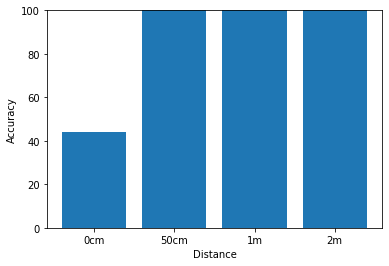

In [14]:
import matplotlib.pyplot as plt

_0cm = acc_0cm / len(res_0cm) * 100
_50cm = acc_50cm / len(res_50cm) * 100
_1m = acc_1m / len(res_1m) * 100
_2m = acc_2m / len(res_2m) * 100

x = np.arange(4)
testCase_num = ['0cm', '50cm', '1m', '2m']
values = [_0cm, _50cm, _1m, _2m]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Distance')
plt.ylabel('Accuracy')

plt.show()